# Forecasting Diaper Demand

Brendan Reed  
12/9/2025

### Import Packages

In [508]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

### Import Data

In [509]:
df = pd.read_csv("data/diapers.csv")

df.head()

Timestamp BRANCH ZIP CODE SIZE  # PACKS SIZE.1  # PACKS.1 SIZE.2  \
0   9/7/2021 0:00:00     GG    63011    1      3.0    NaN        NaN    NaN   
1   9/7/2021 0:00:00     GG    63011   3T      2.0    NaN        NaN    NaN   
2  9/14/2021 0:00:00     GG    63118    5      2.0    NaN        NaN    NaN   
3  9/14/2021 0:00:00     GG    63118    6      2.0    NaN        NaN    NaN   
4  9/14/2021 0:00:00     GG    63125    5      2.0    NaN        NaN    NaN   

   # PACKS.2  TOTAL            DATE      MONTH  YEAR DAY WEEKDAY  
0        NaN      3  September 2021  September  2021   7     Tue  
1        NaN      2  September 2021  September  2021   7     Tue  
2        NaN      2  September 2021  September  2021  14     Tue  
3        NaN      2  September 2021  September  2021  14     Tue  
4        NaN      2  September 2021  September  2021  14     Tue

In [510]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59425 entries, 0 to 59424
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Timestamp  50120 non-null  object 
 1   BRANCH     50117 non-null  object 
 2   ZIP CODE   50113 non-null  object 
 3   SIZE       49967 non-null  object 
 4   # PACKS    50090 non-null  float64
 5   SIZE.1     7687 non-null   object 
 6   # PACKS.1  7595 non-null   float64
 7   SIZE.2     1648 non-null   object 
 8   # PACKS.2  2491 non-null   float64
 9   TOTAL      59425 non-null  int64  
 10  DATE       59425 non-null  object 
 11  MONTH      50120 non-null  object 
 12  YEAR       50120 non-null  object 
 13  DAY        50120 non-null  object 
 14  WEEKDAY    50120 non-null  object 
dtypes: float64(3), int64(1), object(11)
memory usage: 6.8+ MB


## Cleaning Data

Choose only desired columns

In [511]:
df = df[[
    'Timestamp', 'BRANCH', 'ZIP CODE', 'SIZE', '# PACKS', 'SIZE.1',
    '# PACKS.1', 'SIZE.2', '# PACKS.2', 'TOTAL'
]]

Make all column names lower case

In [512]:
df.columns = [item.lower() for item in list(df.columns)]

Filter to only Weber Road

In [513]:
df = df[df['branch'] == "WR"]

Create a row for each pair of sizes and # packs

In [514]:
size_cols = ["size", "size.1", "size.2"]
pack_cols = ["# packs", "# packs.1", "# packs.2"]

pieces = []

for i in range(3):  # force 3 iterations
    temp = df[["timestamp", "branch", "zip code"]].copy()
    temp["size"] = df[size_cols[i]]
    temp["# packs"] = df[pack_cols[i]]
    pieces.append(temp)

df = pd.concat(pieces, ignore_index=True)


Drop rows where both size and # packs is NA

In [515]:
df = df.dropna(subset=["size", "# packs"], how="all")

Preview data

In [516]:
df.head()

timestamp branch zip code size  # packs
0  9/3/2021 0:00:00     WR    63125    6      2.0
1  9/3/2021 0:00:00     WR    63123    3      2.0
2  9/7/2021 0:00:00     WR    63125    4      2.0
3  9/7/2021 0:00:00     WR    63118    n      6.0
4  9/7/2021 0:00:00     WR    63118    n      3.0

Check for missing values

In [517]:
pd.DataFrame({
    "NaN Count": df.isna().sum(),
    "Total Rows": len(df),
    "Percent NaN": df.isna().mean() * 100
})


NaN Count  Total Rows  Percent NaN
timestamp          0       12506     0.000000
branch             0       12506     0.000000
zip code           4       12506     0.031985
size             444       12506     3.550296
# packs           25       12506     0.199904

See unique sizes

In [518]:
list(df["size"].unique())

['6',
 '3',
 '4',
 'n',
 '2',
 '3t',
 '1',
 '5',
 'N',
 '3T',
 '2T',
 '2t',
 'adult',
 '4t',
 '4T',
 nan,
 '7']

Some sizes have duplicates or are not valid.  
Fixes: 
- 'n' and 'N' need to be combined
- 2t and 2T need to be combined for pullups (same with 3t/3T and 4t/4T)
- size 7 needs to be added to nan (we do not give out size 7)

In [519]:
# cast all sizes to strings
df['size'] = df['size'].astype(str)

# make all letters in df["size"] upper case
df["size"] = [x.upper() for x in df["size"]]

# replace size 7 with "Not a Number"
df["size"] = df["size"].replace("7", "NAN")

Now there should be no duplicates of sizes.

In [520]:
list(df["size"].unique())

['6', '3', '4', 'N', '2', '3T', '1', '5', '2T', 'ADULT', '4T', 'NAN']

Create date and month columns

In [521]:
# convert timestamp column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# create month column
df['month'] = df['timestamp'].dt.to_period('M')

# create date column
df['date'] = pd.to_datetime(df['timestamp']).dt.date

# remove timestamp column
df = df.drop('timestamp', axis=1)


Create pivot table to see totals for each size by month

In [522]:
# Replace real NaN in size with a category name
df['size_cat'] = df['size'].astype('object').fillna('NaN')

# Build pivot table
table = df.pivot_table(
    index='month',
    columns='size_cat',
    values='# packs',
    aggfunc='sum',
    fill_value=0,
    dropna=False   # <-- keeps all categories
)




In [523]:
table['total'] = table.sum(axis=1)
table['adj total'] = table['total'] - table['NAN']
table['month2'] = table.index.month
table['year'] = table.index.year
table['adj total 2'] = table['total'] - (table['NAN'] + table['2T'] + table['3T'] + table['4T'] + table['ADULT'])

In [524]:
table.head()

size_cat     1     2   2T     3   3T     4   4T     5     6  ADULT     N  NAN  \
month                                                                           
1902-10    0.0   0.0  0.0   0.0  0.0   0.0  0.0   2.0   0.0    0.0   0.0  0.0   
2021-09    9.0  15.0  0.0  18.0  6.0  24.0  0.0  20.0  16.0    0.0  15.0  0.0   
2021-10    9.0  14.0  6.0  27.0  6.0  27.0  0.0  48.0  30.0    0.0  15.0  0.0   
2021-11   14.0  28.0  2.0  39.0  2.0  34.0  0.0  44.0  42.0    0.0  12.0  0.0   
2021-12   31.0  30.0  0.0  43.0  4.0  32.0  0.0  46.0  50.0    0.0  12.0  0.0   

size_cat  total  adj total  month2  year  adj total 2  
month                                                  
1902-10     2.0        2.0      10  1902          2.0  
2021-09   123.0      123.0       9  2021        117.0  
2021-10   182.0      182.0      10  2021        170.0  
2021-11   217.0      217.0      11  2021        213.0  
2021-12   248.0      248.0      12  2021        244.0

In [525]:
table_filtered = table[(table.index.year >=2023)].copy()

Drop December 2025 - incomplete data

In [526]:
table_filtered = table_filtered.loc[table_filtered.index != '2025-12-01']

In [527]:
# Convert PeriodIndex to Timestamp for plotting
table_filtered.index = table_filtered.index.to_timestamp()

In [528]:
# preview pivot table
table_filtered["NAN/total"] = round(table_filtered["NAN"] / table_filtered["total"], 2)

In [529]:
table_filtered.head()

size_cat       1     2   2T     3    3T     4   4T     5      6  ADULT     N  \
month                                                                          
2023-01-01   8.0  17.0  5.0  36.0   2.0  61.0  1.0  66.0  100.0    1.0   3.0   
2023-02-01   6.0  11.0  5.0  24.0   4.0  43.0  0.0  79.0   79.0    0.0   4.0   
2023-03-01  11.0  15.0  5.0  42.0   2.0  48.0  5.0  61.0   92.0    0.0   6.0   
2023-04-01   9.0  13.0  5.0  33.0   6.0  35.0  0.0  66.0   83.0    0.0   8.0   
2023-05-01  12.0  11.0  2.0  31.0  12.0  54.0  0.0  58.0  108.0    0.0  11.0   

size_cat    NAN  total  adj total  month2  year  adj total 2  NAN/total  
month                                                                    
2023-01-01  0.0  300.0      300.0       1  2023        291.0        0.0  
2023-02-01  0.0  255.0      255.0       2  2023        246.0        0.0  
2023-03-01  0.0  287.0      287.0       3  2023        275.0        0.0  
2023-04-01  0.0  258.0      258.0       4  2023        247.0        0.0  
2023-05-01  0.0  299.0      299.0       5  2023        285.0        0.0

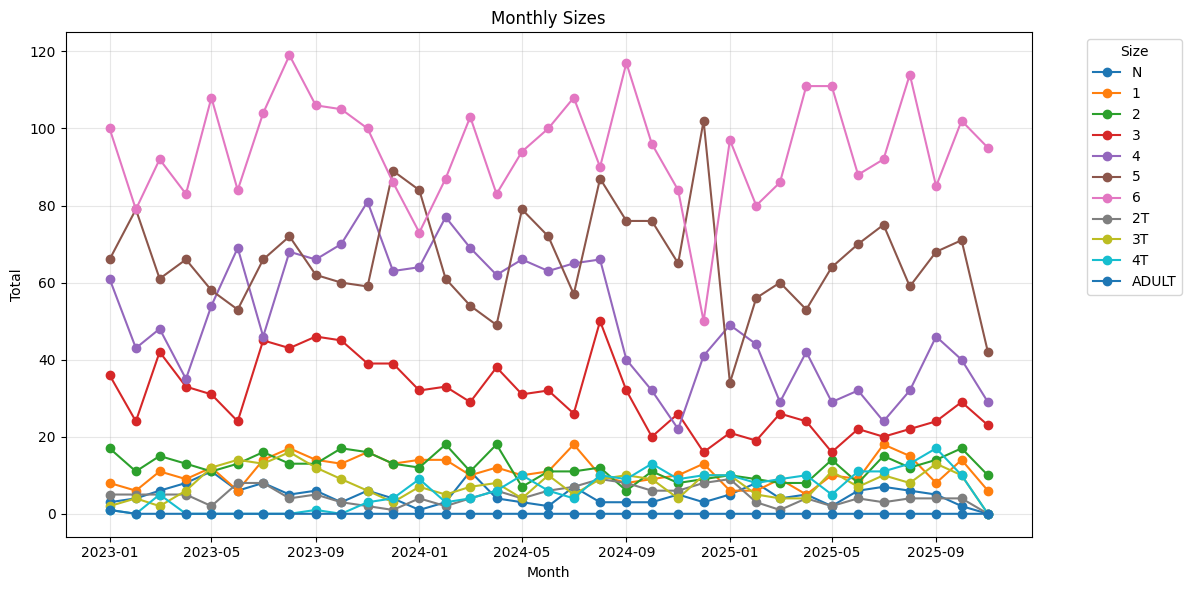

In [530]:
size_cols = ['N', '1', '2', '3', '4', '5', '6', '2T', '3T', '4T', 'ADULT']

plt.figure(figsize=(12,6))

for col in size_cols:
    plt.plot(table_filtered.index, table_filtered[col], marker='o', label=col)

plt.title('Monthly Sizes')
plt.xlabel('Month')
plt.ylabel('Total')
plt.legend(title='Size', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Create pivot table that shows proportions of each size to monthly totals

In [531]:
size_cols = ['N', '1', '2', '3', '4', '5', '6', '2T', '3T', '4T', 'ADULT']


# Create a new DataFrame for proportions
prop_table = table_filtered[size_cols].div(table_filtered['adj total'], axis=0)

# Round to 2 decimals for readability
prop_table = prop_table.round(2)

<Figure size 1200x600 with 0 Axes>

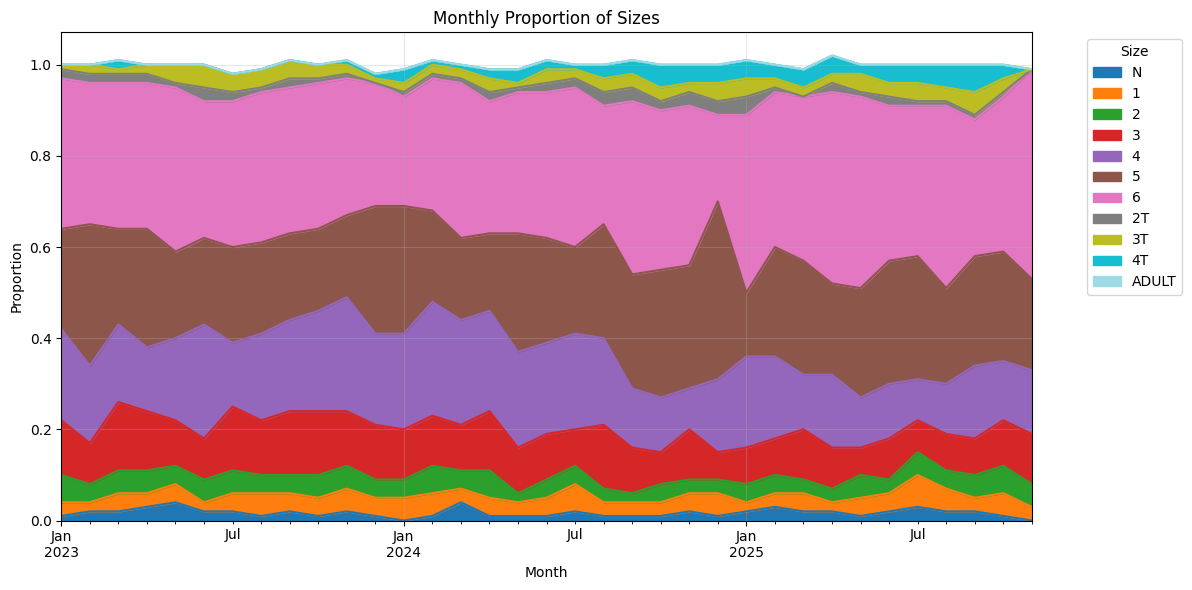

In [532]:
plt.figure(figsize=(12,6))

# stacked area plot
prop_table.plot(kind='area', stacked=True, figsize=(12,6), cmap='tab20')

plt.title('Monthly Proportion of Sizes')
plt.xlabel('Month')
plt.ylabel('Proportion')
plt.legend(title='Size', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [533]:
# Total area (sum of proportions over all months)
total_area = prop_table[size_cols].sum()

total_area_percent = (total_area / total_area.sum())

Overall diaper size proportions from 2023 - 2025

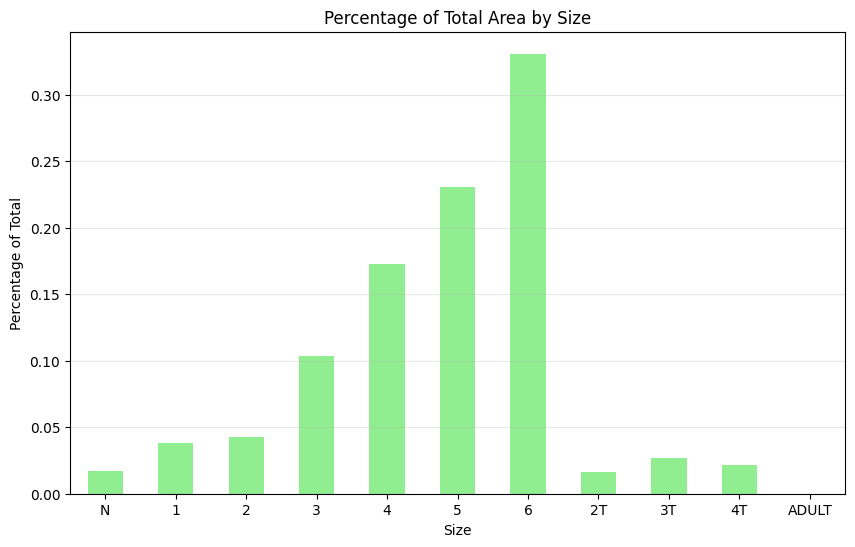

In [534]:
total_area_percent.plot(kind='bar', figsize=(10,6), color='lightgreen')

plt.title('Percentage of Total Area by Size')
plt.xlabel('Size')
plt.ylabel('Percentage of Total')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()


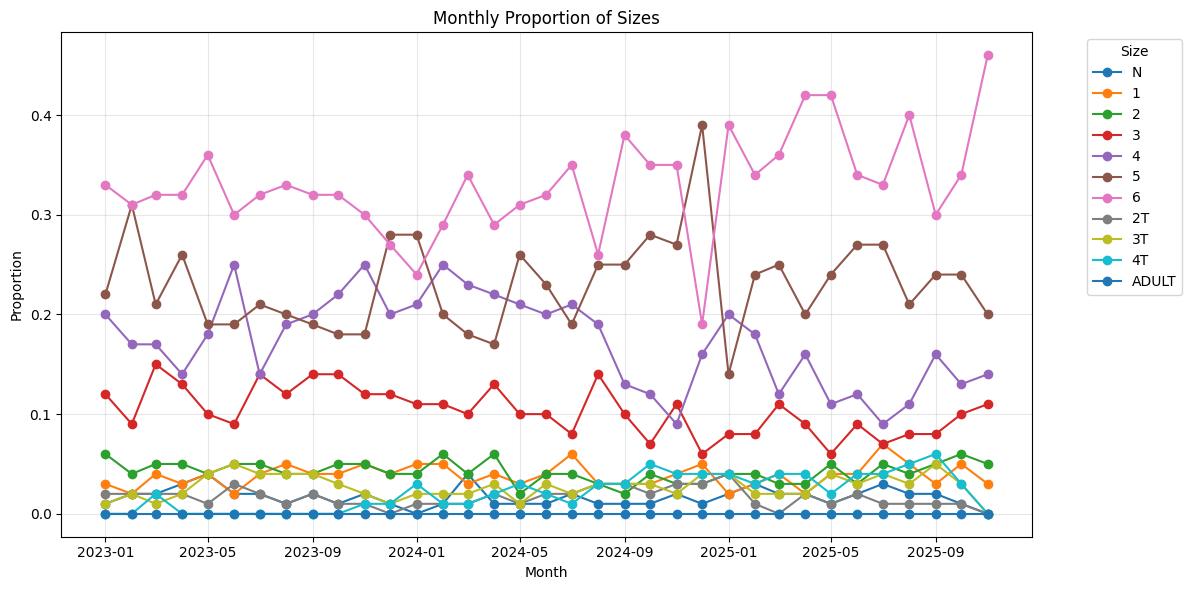

In [535]:
plt.figure(figsize=(12,6))

for col in size_cols:
    plt.plot(prop_table.index, prop_table[col], marker='o', label=col)

plt.title('Monthly Proportion of Sizes')
plt.xlabel('Month')
plt.ylabel('Proportion')
plt.legend(title='Size', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [536]:
prop_table.loc[["2023-01-01", "2025-11-01"],:]

size_cat       N     1     2     3     4     5     6    2T    3T   4T  ADULT
month                                                                       
2023-01-01  0.01  0.03  0.06  0.12  0.20  0.22  0.33  0.02  0.01  0.0    0.0
2025-11-01  0.00  0.03  0.05  0.11  0.14  0.20  0.46  0.00  0.00  0.0    0.0

### Conclusions:
Size 6 has seen an upward trend proportionally, while other sizes have seen downward trends. At some points, less size 6 diapers are given out than size 5. This is probably due to running out of size 6 and people choosing size 5 instead. For the biggest size 6 dip in late 2024, the data point could be removed and interpolated, which could improve forcasting.

Options for generalizing proportions to the future:
- Look at total proportions for only the last 12 months
- Try to predict linear trends in proportions  

Use cases:
- Proportions could be used to fill in missing values for diaper sizes
- After total diapers distributed is predicted for future months, the total can be multiplied with proportions for sizes to predict number of sizes given out each month

Create pivot table showing diaper totals by month for each year

In [537]:
totals_by_month = table_filtered.pivot_table(
    index='month2',
    columns='year',
    values='total',
    aggfunc='sum'
)

totals_by_month.loc[12,2025] = np.nan

In [538]:
totals_by_month
pivot = totals_by_month
pivot.head()

year     2023   2024   2025
month2                     
1       300.0  300.0  270.0
2       255.0  303.0  267.0
3       287.0  302.0  250.0
4       258.0  286.0  294.0
5       299.0  308.0  290.0

Graph monthly totals by year to compare trends

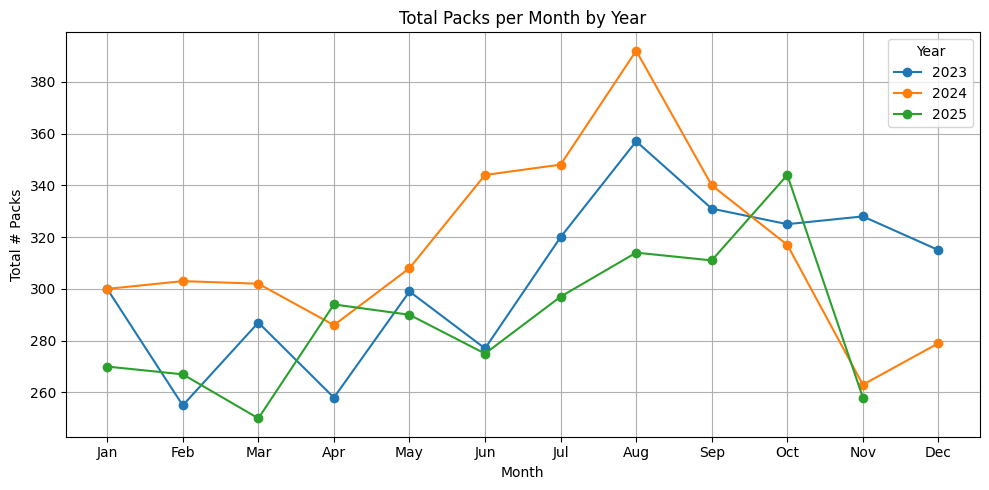

In [539]:
plt.figure(figsize=(10,5))
for year in totals_by_month.columns:
    plt.plot(totals_by_month.index, totals_by_month[year], marker='o', label=str(year))

plt.xlabel("Month")
plt.ylabel("Total # Packs")
plt.title("Total Packs per Month by Year")
plt.xticks(ticks=range(1,13), labels=[
    "Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"
])
plt.legend(title="Year")
plt.grid(True)
plt.tight_layout()
plt.show()


Conclusion: 2023, 2024, and 2025 follow similar seasonal trends. Totals increase in summer and decrease in winter.

## Creating Models

### Modeling Total Diapers per Month

About holt-winters...

Deciding between Additive and Multiplicative

In [540]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Flatten table to time series (Month-Year index)
ts = pivot.stack()
ts.index = pd.date_range(start='2023-01-01', periods=len(ts), freq='MS')

# Additive Holt-Winters
model_add = ExponentialSmoothing(ts, trend='add', seasonal='add', seasonal_periods=12).fit()

# Multiplicative Holt-Winters
model_mul = ExponentialSmoothing(ts, trend='add', seasonal='mul', seasonal_periods=12).fit()

print("Additive AIC:", model_add.aic)
print("Multiplicative AIC:", model_mul.aic)

Additive AIC: 252.76239663602357
Multiplicative AIC: 251.14781997365506


Conclusion: go with multiplicative

In [541]:
table_filtered.loc["2025-12-01","total"] = np.nan

In [542]:
# Create a pandas Series for the totals
ts = table_filtered["total"].sort_index()  # make sure sorted by date
ts = ts.interpolate(method='time')

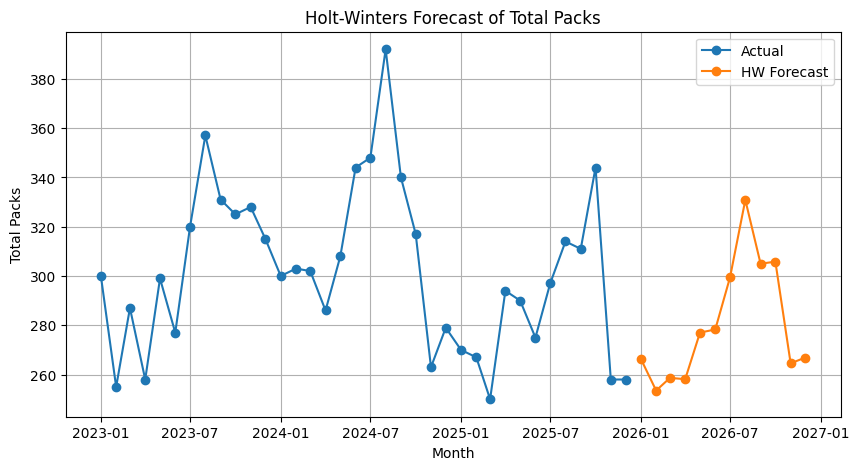

In [543]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# Fit Holt-Winters seasonal model (monthly data, yearly seasonality)
hw_model = ExponentialSmoothing(ts, seasonal='mul', seasonal_periods=12)
hw_fit = hw_model.fit()

# Forecast next 12 months
hw_forecast = hw_fit.forecast(12)

# Plot
plt.figure(figsize=(10,5))
plt.plot(ts.index, ts, label='Actual', marker='o')
plt.plot(hw_forecast.index, hw_forecast, label='HW Forecast', marker='o')
plt.title('Holt-Winters Forecast of Total Packs')
plt.xlabel('Month')
plt.ylabel('Total Packs')
plt.legend()
plt.grid(True)
plt.show()


## Storage

In [544]:
storage = pd.read_csv("data/storage.csv", index_col=0)

storage["Proportion"] = round(storage["Total"] / sum(storage["Total"]), 2)

storage

Total  Proportion
Shelf                   
N         15        0.03
1         63        0.13
2         63        0.13
3         90        0.19
4         60        0.13
5         60        0.13
6        120        0.25

In [545]:
size_cols = ['N', '1', '2', '3', '4', '5', '6']


# Create a new DataFrame for proportions
prop_table = table_filtered[size_cols].div(table_filtered['adj total 2'], axis=0)

# Round to 2 decimals for readability
prop_table = prop_table.round(2)

# only look at the past year
subset = prop_table.loc["2024-12-01":"2025-11-01"]

In [546]:
# Total area (sum of proportions over all months)
total_area = subset[size_cols].sum()

total_area_percent = round(total_area / total_area.sum(),2)

Find average packs per month given out

In [547]:
one_year = table_filtered[size_cols].loc['2024-12-01':'2025-11-01']

In [548]:
averages = [math.ceil(x) for x in one_year.mean()]

In [549]:
storage["Est. Loss/Month"] = averages
storage["Est. Loss/Month Prop."] = total_area_percent

In [550]:
storage[["Total", "Est. Loss/Month", "Proportion", "Est. Loss/Month Prop."]]

Total  Est. Loss/Month  Proportion  Est. Loss/Month Prop.
Shelf                                                           
N         15                5        0.03                   0.02
1         63               10        0.13                   0.04
2         63               12        0.13                   0.05
3         90               22        0.19                   0.09
4         60               37        0.13                   0.15
5         60               63        0.13                   0.26
6        120               93        0.25                   0.39

In [551]:
storage['New Stock'] = storage['Total'].sum() * storage["Est. Loss/Month Prop."]

In [552]:
storage['New Stock'] = [math.ceil(x) for x in storage['New Stock']]

In [553]:
storage

Total  Proportion  Est. Loss/Month  Est. Loss/Month Prop.  New Stock
Shelf                                                                      
N         15        0.03                5                   0.02         10
1         63        0.13               10                   0.04         19
2         63        0.13               12                   0.05         24
3         90        0.19               22                   0.09         43
4         60        0.13               37                   0.15         71
5         60        0.13               63                   0.26        123
6        120        0.25               93                   0.39        184

In [554]:
# table for how many months we could last with our shelves fully stocked
current = storage['Total']
current_months = round(storage['Total'] / storage['Est. Loss/Month'], 1)
new = storage["New Stock"]
new_months = round(storage["New Stock"] / storage['Est. Loss/Month'], 1)

stock = pd.DataFrame({
    'current': current,
    'current_months': current_months,
    'new': new,
    'new_months': new_months
})

stock


current  current_months  new  new_months
Shelf                                          
N           15             3.0   10         2.0
1           63             6.3   19         1.9
2           63             5.2   24         2.0
3           90             4.1   43         2.0
4           60             1.6   71         1.9
5           60             1.0  123         2.0
6          120             1.3  184         2.0

## Use proportions to estimate missing data

Move up more

In [555]:
size_cols = ['N', '1', '2', '3', '4', '5', '6']

In [556]:
df_sizes = subset

In [557]:
df_nan = table_filtered[['NAN']]

In [558]:
df_nan = df_nan.reindex(df_sizes.index)

In [559]:
result = df_sizes.mul(df_nan['NAN'], axis=0)
result = result.round(0)

In [560]:
df_orig = table_filtered[size_cols].loc['2024-12-01':'2025-11-01']

In [561]:
df_total = df_orig + result
df_total

size_cat      N     1     2     3     4      5      6
month                                                
2024-12-01  3.0  14.0  10.0  17.0  44.0  109.0   54.0
2025-01-01  5.0   7.0  11.0  23.0  53.0   37.0  105.0
2025-02-01  9.0   7.0  10.0  22.0  50.0   63.0   90.0
2025-03-01  4.0  10.0   9.0  28.0  31.0   64.0   91.0
2025-04-01  6.0   6.0   9.0  27.0  47.0   59.0  124.0
2025-05-01  2.0  11.0  16.0  18.0  32.0   71.0  123.0
2025-06-01  7.0  10.0   9.0  24.0  35.0   75.0   95.0
2025-07-01  8.0  20.0  16.0  22.0  26.0   82.0  100.0
2025-08-01  7.0  17.0  13.0  24.0  35.0   66.0  127.0
2025-09-01  6.0   9.0  16.0  27.0  51.0   75.0   94.0
2025-10-01  2.0  16.0  20.0  34.0  47.0   83.0  119.0
2025-11-01  0.0   8.0  13.0  29.0  36.0   53.0  119.0

## Stock by Week

Look at weekly breakdowns

In [562]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

In [563]:
df['week_of_month'] = 1 + (df['date'].dt.day - 1) // 7

In [564]:
df

branch zip code   size  # packs    month       date size_cat  \
0         WR    63125      6      2.0  2021-09 2021-09-03        6   
1         WR    63123      3      2.0  2021-09 2021-09-03        3   
2         WR    63125      4      2.0  2021-09 2021-09-07        4   
3         WR    63118      N      6.0  2021-09 2021-09-07        N   
4         WR    63118      N      3.0  2021-09 2021-09-07        N   
5         WR    63130      2      3.0  2021-09 2021-09-07        2   
6         WR    63129     3T      2.0  2021-09 2021-09-08       3T   
7         WR    63123      3      2.0  2021-09 2021-09-09        3   
8         WR    63128      3      2.0  2021-09 2021-09-11        3   
9         WR    63129      1      3.0  2021-09 2021-09-11        1   
10        WR    63129      5      2.0  2021-09 2021-09-11        5   
11        WR    63123      6      2.0  2021-09 2021-09-13        6   
12        WR    63125      5      2.0  2021-09 2021-09-13        5   
13        WR    63125      6      2.0  2021-09 2021-09-13        6   
14        WR    63125      5      2.0  2021-09 2021-09-13        5   
15        WR    63111      4      2.0  2021-09 2021-09-13        4   
16        WR    63660      5      2.0  2021-09 2021-09-13        5   
17        WR    63125      5      2.0  2021-09 2021-09-13        5   
18        WR    63025      3      2.0  2021-09 2021-09-14        3   
19        WR    63129      3      2.0  2021-09 2021-09-15        3   
20        WR    63123      3      2.0  2021-09 2021-09-15        3   
21        WR    63123      5      2.0  2021-09 2021-09-15        5   
22        WR    63125      4      2.0  2021-09 2021-09-15        4   
23        WR    63125      1      3.0  2021-09 2021-09-16        1   
24        WR    63123      4      2.0  2021-09 2021-09-17        4   
25        WR    63119      1      3.0  2021-09 2021-09-17        1   
26        WR    63144      3      2.0  2021-09 2021-09-17        3   
27        WR    63125      4      2.0  2021-09 2021-09-21        4   
28        WR    63123     3T      2.0  2021-09 2021-09-21       3T   
29        WR    63123      6      2.0  2021-09 2021-09-21        6   
30        WR    63123      5      2.0  2021-09 2021-09-21        5   
31        WR    63123      3      2.0  2021-09 2021-09-21        3   
32        WR    63123      N      3.0  2021-09 2021-09-22        N   
33        WR    63123     3T      2.0  2021-09 2021-09-22       3T   
34        WR    63116      4      2.0  2021-09 2021-09-23        4   
35        WR    63116      4      2.0  2021-09 2021-09-23        4   
36        WR    63116      5      2.0  2021-09 2021-09-23        5   
37        WR    63116      6      2.0  2021-09 2021-09-23        6   
38        WR    63123      N      3.0  2021-09 2021-09-24        N   
39        WR    63125      5      2.0  2021-09 2021-09-24        5   
40        WR    63129      2      3.0  2021-09 2021-09-24        2   
41        WR    63125      2      3.0  2021-09 2021-09-24        2   
42        WR    63125      4      2.0  2021-09 2021-09-24        4   
43        WR    63125      6      2.0  2021-09 2021-09-24        6   
44        WR    63125      6      2.0  2021-09 2021-09-24        6   
45        WR    63125      5      2.0  2021-09 2021-09-24        5   
46        WR    63125      2      3.0  2021-09 2021-09-24        2   
47        WR    63116      4      2.0  2021-09 2021-09-28        4   
48        WR    63116      4      2.0  2021-09 2021-09-29        4   
49        WR    63116      3      2.0  2021-09 2021-09-29        3   
50        WR    63129      4      2.0  2021-09 2021-09-30        4   
51        WR    63129      2      3.0  2021-09 2021-09-30        2   
52        WR    63125      4      2.0  2021-09 2021-09-30        4   
53        WR    63125      6      2.0  2021-09 2021-09-30        6   
54        WR    63123      3      2.0  2021-10 2021-10-01        3   
55        WR    63109      6      2.0  2021-10 2021-10-03        6   
56        WR    

In [565]:
df['year'] = df['date'].dt.year
df['month_num'] = df['date'].dt.month

pivot = df.pivot_table(
    index=['year', 'month_num', 'week_of_month'],   # rows
    columns='size_cat',                              # size categories
    values='# packs',
    aggfunc='sum',
    fill_value=0
)


In [566]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)



In [567]:
pivot_1yr = pivot.loc[(2024,12,1):(2025,11,5)].copy()
pivot_1yr["TOTAL"] = pivot_1yr.sum(axis=1)

In [568]:
pivot_1yr

size_cat                        1    2   2T     3   3T     4   4T     5     6  \
year month_num week_of_month                                                    
2024 12        1              6.0  4.0  2.0   6.0  3.0   7.0  8.0  58.0   0.0   
               2              2.0  3.0  6.0   4.0  5.0  11.0  0.0  21.0  18.0   
               3              2.0  2.0  0.0   1.0  0.0  15.0  2.0  15.0  18.0   
               4              1.0  0.0  0.0   2.0  0.0   2.0  0.0   7.0   8.0   
               5              2.0  0.0  0.0   3.0  2.0   6.0  0.0   1.0   6.0   
2025 1         1              0.0  2.0  2.0   2.0  2.0   4.0  2.0  10.0  24.0   
               2              3.0  3.0  0.0   2.0  0.0  11.0  2.0  12.0  35.0   
               3              1.0  0.0  6.0   7.0  0.0  14.0  1.0   1.0   5.0   
               4              0.0  1.0  1.0   6.0  8.0  12.0  5.0   4.0  13.0   
               5              2.0  4.0  0.0   4.0  0.0   8.0  0.0   7.0  20.0   
     2         1              2.0  2.0  1.0   5.0  2.0  24.0  4.0  24.0  32.0   
               2              1.0  1.0  1.0   4.0  2.0   5.0  1.0  13.0  10.0   
               3              2.0  3.0  1.0   3.0  0.0   6.0  1.0   6.0  14.0   
               4              1.0  3.0  0.0   7.0  1.0   9.0  2.0  13.0  24.0   
     3         1              3.0  2.0  0.0  11.0  1.0  11.0  3.0  17.0  31.0   
               2              3.0  1.0  1.0   8.0  2.0   8.0  0.0  14.0  16.0   
               3              2.0  2.0  0.0   2.0  0.0   2.0  4.0  14.0  17.0   
               4              1.0  2.0  0.0   3.0  1.0   6.0  2.0  12.0  16.0   
               5              0.0  1.0  0.0   2.0  0.0   2.0  0.0   3.0   6.0   
     4         1              3.0  1.0  2.0   5.0  1.0   8.0  3.0  22.0  31.0   
               2              2.0  2.0  0.0  10.0  0.0  15.0  2.0  12.0  39.0   
               3              0.0  3.0  1.0   7.0  0.0   4.0  3.0   3.0  15.0   
               4              0.0  2.0  1.0   1.0  3.0   9.0  2.0   9.0  14.0   
               5              0.0  0.0  0.0   1.0  0.0   6.0  0.0   7.0  12.0   
     5         1              4.0  0.0  1.0   3.0  6.0   6.0  3.0  22.0  39.0   
               2              1.0  7.0  0.0   4.0  5.0  12.0  1.0  27.0  25.0   
               3              1.0  1.0  0.0   6.0  0.0   7.0  0.0   6.0  24.0   
               4              1.0  1.0  1.0   0.0  0.0   2.0  1.0   4.0  11.0   
               5              3.0  5.0  0.0   3.0  0.0   2.0  0.0   5.0  12.0   
     6         1              2.0  4.0  2.0   7.0  1.0   9.0  6.0  28.0  34.0   
               2              6.0  2.0  0.0   3.0  4.0   9.0  2.0  21.0  23.0   
               3              0.0  0.0  1.0   5.0  0.0   7.0  1.0  10.0   9.0   
               4              1.0  2.0  0.0   6.0  2.0   5.0  2.0   9.0  16.0   
               5              0.0  0.0  1.0   1.0  0.0   2.0  0.0   2.0   6.0   
     7         1              3.0  6.0  2.0   6.0  3.0   2.0  3.0  23.0  22.0   
               2              2.0  2.0  0.0   4.0  3.0  10.0  6.0  21.0  39.0   
               3              0.0  1.0  0.0   3.0  1.0   6.0  0.0  13.0  13.0   
               4              6.0  6.0  0.0   2.0  1.0   4.0  2.0  11.0  12.0   
               5              7.0  0.0  1.0   5.0  2.0   2.0  0.0   7.0   6.0   
     8         1              5.0  3.0  0.0   7.0  1.0   5.0  7.0  20.0  48.0   
               2              3.0  0.0  2.0   6.0  2.0   7.0  5.0  13.0  17.0   
               3              5.0  3.0  1.0   2.0  3.0   8.0  0.0  12.0  18.0   
               4              2.0  5.0  1.0   4.0  2.0  11.0  1.0  12.0  25.0   
               5              0.0  1.0  0.0   3.0  0.0   1.0  0.0   2.0   6.0   
     9         1              5.0  2.0  2.0   8.0  5.0  12.0  4.0  19.0  30.0   
               2              0.0  5.0  1.0   4.0  2.0  15.0  7.0  16.0  25.0   
               3              1.0  4.0  0.0   5.0  4.0  12.0  4.0  15.0  11.0   
               4              1

In [569]:
# Assume your pivot_1yr table is called pivot_1yr
import pandas as pd

# Compute monthly totals of the TOTAL column
monthly_totals = pivot_1yr.groupby(level=['year','month_num'])['TOTAL'].transform('sum')

# Divide all size columns by monthly total to get proportion
size_columns = ['1','2','2T','3','3T','4','4T','5','6','ADULT','N','NAN']

# Create a new table with proportions
pivot_1yr_prop = pivot_1yr.copy()

# Optional: also include proportion of total per week
pivot_1yr_prop['TOTAL_prop'] = round(pivot_1yr['TOTAL'] / monthly_totals,2)

pivot_1yr_prop


size_cat                        1    2   2T     3   3T     4   4T     5     6  \
year month_num week_of_month                                                    
2024 12        1              6.0  4.0  2.0   6.0  3.0   7.0  8.0  58.0   0.0   
               2              2.0  3.0  6.0   4.0  5.0  11.0  0.0  21.0  18.0   
               3              2.0  2.0  0.0   1.0  0.0  15.0  2.0  15.0  18.0   
               4              1.0  0.0  0.0   2.0  0.0   2.0  0.0   7.0   8.0   
               5              2.0  0.0  0.0   3.0  2.0   6.0  0.0   1.0   6.0   
2025 1         1              0.0  2.0  2.0   2.0  2.0   4.0  2.0  10.0  24.0   
               2              3.0  3.0  0.0   2.0  0.0  11.0  2.0  12.0  35.0   
               3              1.0  0.0  6.0   7.0  0.0  14.0  1.0   1.0   5.0   
               4              0.0  1.0  1.0   6.0  8.0  12.0  5.0   4.0  13.0   
               5              2.0  4.0  0.0   4.0  0.0   8.0  0.0   7.0  20.0   
     2         1              2.0  2.0  1.0   5.0  2.0  24.0  4.0  24.0  32.0   
               2              1.0  1.0  1.0   4.0  2.0   5.0  1.0  13.0  10.0   
               3              2.0  3.0  1.0   3.0  0.0   6.0  1.0   6.0  14.0   
               4              1.0  3.0  0.0   7.0  1.0   9.0  2.0  13.0  24.0   
     3         1              3.0  2.0  0.0  11.0  1.0  11.0  3.0  17.0  31.0   
               2              3.0  1.0  1.0   8.0  2.0   8.0  0.0  14.0  16.0   
               3              2.0  2.0  0.0   2.0  0.0   2.0  4.0  14.0  17.0   
               4              1.0  2.0  0.0   3.0  1.0   6.0  2.0  12.0  16.0   
               5              0.0  1.0  0.0   2.0  0.0   2.0  0.0   3.0   6.0   
     4         1              3.0  1.0  2.0   5.0  1.0   8.0  3.0  22.0  31.0   
               2              2.0  2.0  0.0  10.0  0.0  15.0  2.0  12.0  39.0   
               3              0.0  3.0  1.0   7.0  0.0   4.0  3.0   3.0  15.0   
               4              0.0  2.0  1.0   1.0  3.0   9.0  2.0   9.0  14.0   
               5              0.0  0.0  0.0   1.0  0.0   6.0  0.0   7.0  12.0   
     5         1              4.0  0.0  1.0   3.0  6.0   6.0  3.0  22.0  39.0   
               2              1.0  7.0  0.0   4.0  5.0  12.0  1.0  27.0  25.0   
               3              1.0  1.0  0.0   6.0  0.0   7.0  0.0   6.0  24.0   
               4              1.0  1.0  1.0   0.0  0.0   2.0  1.0   4.0  11.0   
               5              3.0  5.0  0.0   3.0  0.0   2.0  0.0   5.0  12.0   
     6         1              2.0  4.0  2.0   7.0  1.0   9.0  6.0  28.0  34.0   
               2              6.0  2.0  0.0   3.0  4.0   9.0  2.0  21.0  23.0   
               3              0.0  0.0  1.0   5.0  0.0   7.0  1.0  10.0   9.0   
               4              1.0  2.0  0.0   6.0  2.0   5.0  2.0   9.0  16.0   
               5              0.0  0.0  1.0   1.0  0.0   2.0  0.0   2.0   6.0   
     7         1              3.0  6.0  2.0   6.0  3.0   2.0  3.0  23.0  22.0   
               2              2.0  2.0  0.0   4.0  3.0  10.0  6.0  21.0  39.0   
               3              0.0  1.0  0.0   3.0  1.0   6.0  0.0  13.0  13.0   
               4              6.0  6.0  0.0   2.0  1.0   4.0  2.0  11.0  12.0   
               5              7.0  0.0  1.0   5.0  2.0   2.0  0.0   7.0   6.0   
     8         1              5.0  3.0  0.0   7.0  1.0   5.0  7.0  20.0  48.0   
               2              3.0  0.0  2.0   6.0  2.0   7.0  5.0  13.0  17.0   
               3              5.0  3.0  1.0   2.0  3.0   8.0  0.0  12.0  18.0   
               4              2.0  5.0  1.0   4.0  2.0  11.0  1.0  12.0  25.0   
               5              0.0  1.0  0.0   3.0  0.0   1.0  0.0   2.0   6.0   
     9         1              5.0  2.0  2.0   8.0  5.0  12.0  4.0  19.0  30.0   
               2              0.0  5.0  1.0   4.0  2.0  15.0  7.0  16.0  25.0   
               3              1.0  4.0  0.0   5.0  4.0  12.0  4.0  15.0  11.0   
               4              1

In [570]:
import pandas as pd

# Assuming your pivot table is called pivot_1yr and 'TOTAL' is the sum for each week

# Reset index to make grouping easier
pivot_1yr_reset = pivot_1yr.reset_index()

# Define a new column for part of the month
pivot_1yr_reset['month_part'] = pivot_1yr_reset['week_of_month'].apply(lambda x: 1 if x in [1, 2] else 2)

# Group by year, month_num, and month_part, summing all columns
pivot_1yr_grouped = pivot_1yr_reset.groupby(['year', 'month_num', 'month_part']).sum(numeric_only=True)

# Compute proportion of TOTAL per part relative to monthly total
# First get monthly total by year and month
monthly_total = pivot_1yr_reset.groupby(['year', 'month_num'])['TOTAL'].sum()

# Merge to get monthly total for each part
pivot_1yr_grouped = pivot_1yr_grouped.merge(monthly_total.rename('monthly_total'), on=['year', 'month_num'])

# Calculate proportion
pivot_1yr_grouped['TOTAL_prop'] = pivot_1yr_grouped['TOTAL'] / pivot_1yr_grouped['monthly_total']

# Optionally drop 'monthly_total' if not needed
pivot_1yr_grouped = pivot_1yr_grouped.drop(columns='monthly_total')

pivot_1yr_grouped


week_of_month     1    2   2T     3    3T     4    4T     5  \
year month_num                                                                
2024 12                     3   8.0  7.0  8.0  10.0   8.0  18.0   8.0  79.0   
     12                    12   5.0  2.0  0.0   6.0   2.0  23.0   2.0  23.0   
2025 1                      3   3.0  5.0  2.0   4.0   2.0  15.0   4.0  22.0   
     1                     12   3.0  5.0  7.0  17.0   8.0  34.0   6.0  12.0   
     2                      3   3.0  3.0  2.0   9.0   4.0  29.0   5.0  37.0   
     2                      7   3.0  6.0  1.0  10.0   1.0  15.0   3.0  19.0   
     3                      3   6.0  3.0  1.0  19.0   3.0  19.0   3.0  31.0   
     3                     12   3.0  5.0  0.0   7.0   1.0  10.0   6.0  29.0   
     4                      3   5.0  3.0  2.0  15.0   1.0  23.0   5.0  34.0   
     4                     12   0.0  5.0  2.0   9.0   3.0  19.0   5.0  19.0   
     5                      3   5.0  7.0  1.0   7.0  11.0  18.0   4.0  49.0   
     5                     12   5.0  7.0  1.0   9.0   0.0  11.0   1.0  15.0   
     6                      3   8.0  6.0  2.0  10.0   5.0  18.0   8.0  49.0   
     6                     12   1.0  2.0  2.0  12.0   2.0  14.0   3.0  21.0   
     7                      3   5.0  8.0  2.0  10.0   6.0  12.0   9.0  44.0   
     7                     12  13.0  7.0  1.0  10.0   4.0  12.0   2.0  31.0   
     8                      3   8.0  3.0  2.0  13.0   3.0  12.0  12.0  33.0   
     8                     12   7.0  9.0  2.0   9.0   5.0  20.0   1.0  26.0   
     9                      3   5.0  7.0  3.0  12.0   7.0  27.0  11.0  35.0   
     9                     12   3.0  7.0  1.0  12.0   6.0  19.0   6.0  33.0   
     10                     3   7.0  9.0  4.0  15.0   8.0  20.0  10.0  30.0   
     10                    12   7.0  8.0  0.0  14.0   2.0  20.0   0.0  41.0   
     11                     3   6.0  8.0  0.0  12.0   0.0  19.0   0.0  32.0   
     11                     7   0.0  2.0  0.0  11.0   0.0  10.0   0.0  10.0   

                   6  ADULT    N   NAN  TOTAL  TOTAL_prop  
year month_num                                             
2024 12         18.0    0.0  2.0  12.0  178.0    0.637993  
     12         32.0    0.0  1.0   5.0  101.0    0.362007  
2025 1          59.0    0.0  2.0   9.0  127.0    0.470370  
     1          38.0    0.0  3.0  10.0  143.0    0.529630  
     2          42.0    0.0  5.0  19.0  158.0    0.591760  
     2          38.0    0.0  3.0  10.0  109.0    0.408240  
     3          47.0    0.0  1.0   6.0  139.0    0.556000  
     3          39.0    0.0  3.0   8.0  111.0    0.444000  
     4          70.0    0.0  1.0  22.0  181.0    0.615646  
     4          41.0    0.0  4.0   6.0  113.0    0.384354  
     5          64.0    0.0  0.0  19.0  185.0    0.637931  
     5          47.0    0.0  2.0   7.0  105.0    0.362069  
     6          57.0    0.0  2.0  13.0  178.0    0.647273  
     6          31.0    0.0  4.0   5.0   97.0    0.352727  
     7          61.0    0.0  3.0   7.0  167.0    0.562290  
     7          31.0    0.0  4.0  15.0  130.0    0.437710  
     8          65.0    0.0  2.0   9.0  162.0    0.515924  
     8          49.0    0.0  4.0  20.0  152.0    0.484076  
     9          55.0    0.0  3.0  14.0  179.0    0.575563  
     9          30.0    0.0  2.0  13.0  132.0    0.424437  
     10         58.0    0.0  1.0  13.0  175.0    0.508721  
     10         44.0    0.0  1.0  32.0  169.0    0.491279  
     11         72.0    0.0  0.0  40.0  189.0    0.732558  
     11         23.0    0.0  0.0  13.0   69.0    0.267442

See what the damage is from the first two weeks, then order to replenish